In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as k

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Input, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


Using TensorFlow backend.


In [2]:
df_test = pd.read_csv('../data/annotation/test_annotation.csv').drop(columns = 'Unnamed: 0')
df_train = pd.read_csv('../data/annotation/train_annotation.csv').drop(columns = 'Unnamed: 0')

In [3]:
df_train['images'] = df_train['Filename'].apply(lambda x: x.split('/')[1])
df_test['images'] = df_test['Filename'].apply(lambda x: x.split('/')[1])

In [4]:
df_train['image_flow'] = df_train['Annotation tag'] + '/' + df_train['images']
df_test['image_flow'] = df_test['Annotation tag'] + '/' + df_test['images']

In [5]:
# create new df_test with no duplicates
df_test_flow = df_test[['Annotation tag','image_flow']]
df_test_flow.drop_duplicates(inplace = True)

/Users/kevinlu/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
df_train['Annotation tag'].value_counts(normalize = True)

go             0.442751
stop           0.354687
stopLeft       0.148709
warning        0.024274
goLeft         0.023849
warningLeft    0.005731
Name: Annotation tag, dtype: float64

In [7]:
df_test['Annotation tag'].value_counts(normalize = True)

stop           0.449895
go             0.412444
stopLeft       0.087200
warning        0.024476
goLeft         0.021509
goForward      0.003556
warningLeft    0.000919
Name: Annotation tag, dtype: float64

## Train/Test Data Structure

In [8]:
train = ImageDataGenerator(         
    width_shift_range = 0.2,      # shift horizontal by 0.2
    height_shift_range = 0.2,     # shift vertical by 0.2
    shear_range = 0.2,
    zoom_range = 0.2,             # zoom in by 0.2
    rescale = 1./255,
    fill_mode = 'nearest'
) 

test = ImageDataGenerator(
    rescale = 1./255
)

In [9]:
# from dataframe (annotation)
# test_generator = test.flow_from_dataframe(
#             dataframe=df_test_flow, 
#             directory="../data/test_eda/", 
#             x_col='image_flow', 
#             y_col= 'Annotation tag', 
#             class_mode="categorical", 
#             target_size=(128,128),     # check docs
#             batch_size= 32    #increase 
# )

In [10]:
# from directory
train_data = train.flow_from_directory(
    '../data/sign_train/',
    target_size = (64,64),               # image size __ x __
    batch_size = 64,                       # each model run ___ images
    class_mode = 'binary'
)

test_data = test.flow_from_directory(
    '../data/sign_test/',
    target_size = (64,64),
    batch_size = 64,
    class_mode = 'binary'
)

Found 29721 images belonging to 2 classes.
Found 32306 images belonging to 2 classes.


In [11]:
# create class weight
label_count = {}
tags = ['go','goLeft']

for tag in tags:
    label_count[tag] = len(df_train[df_train['Annotation tag'] == tag])

total_count = sum(label_count.values())

class_weight = {label:total_count/count for label,count in enumerate(label_count.values())}
class_weight

{0: 1.0538655974897586, 1: 19.56472491909385}

In [12]:
batch_size = 32
num_of_test_sample = 32306

## Model

In [13]:
# Model
model = Sequential()

model.add(Conv2D(filters = 40,
                 kernel_size = (1,1),
                 activation = 'relu',
                 input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size = (2,2)))


model.add(Conv2D(40,
                 kernel_size = (2,2),
                 kernel_regularizer = regularizers.l2(0.05),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(30,
                 kernel_size = (3,3),
                 kernel_regularizer = regularizers.l2(0.05),
                 activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))






model.add(Flatten())
model.add(Dense(18,
                activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(9,
                activation = 'relu'))
model.add(Dropout(0.2))

# callbacks
es = EarlyStopping(
    monitor="val_loss",
    min_delta=0.1,
    patience=5,
    restore_best_weights = True
)

rp = ReduceLROnPlateau(factor = 0.01,
                       patience = 2)

callbacks = [es, rp]

# output
model.add(Dense(1,
                activation = 'sigmoid'))


# compile
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

model.summary()


history = model.fit_generator(train_data,
                              epochs = 15,
                              validation_data = test_data,
                              callbacks = callbacks,
                              class_weight= class_weight,
                              verbose = 1 )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 20)        3220      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4500)              0         
_________________________________________________________________
dense (Dense)        

In [14]:
y_pred_class = model.predict_classes(test_data,
                                     num_of_test_sample // batch_size+1,
                                     verbose = 1)

505/505 [==============================] - 66s 131ms/step


In [15]:
y_pred_arg_class = np.argmax(y_pred_class, axis = 1)

In [16]:
matrix = confusion_matrix(test_data.classes, y_pred_class)

In [17]:
pd.DataFrame(matrix, columns= ['actual go', 'actual goLeft'], index=['predicted go','predicted goLeft'])

,actual go,actual goLeft
predicted go,29815,108
predicted goLeft,2368,15


In [18]:
# classification report
report = classification_report(test_data.classes, y_pred_class)

In [19]:
print(report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     29923
           1       0.12      0.01      0.01      2383

    accuracy                           0.92     32306
   macro avg       0.52      0.50      0.49     32306
weighted avg       0.87      0.92      0.89     32306



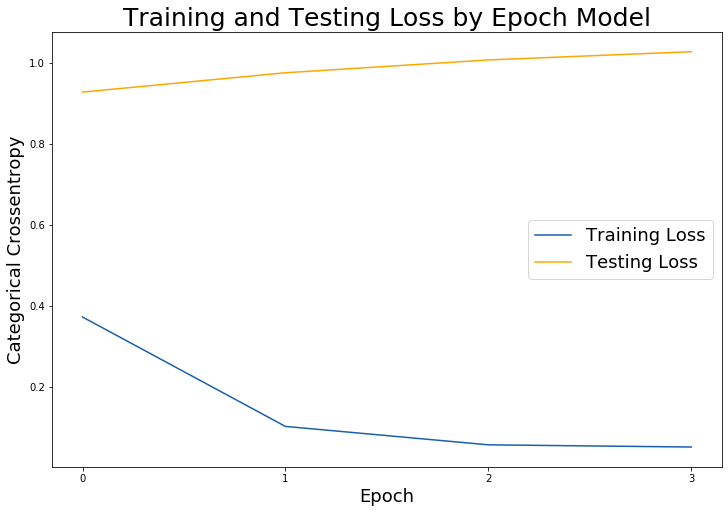

In [26]:
# loss visualization
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch Model', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(4), np.arange(10))
plt.legend(fontsize = 18);

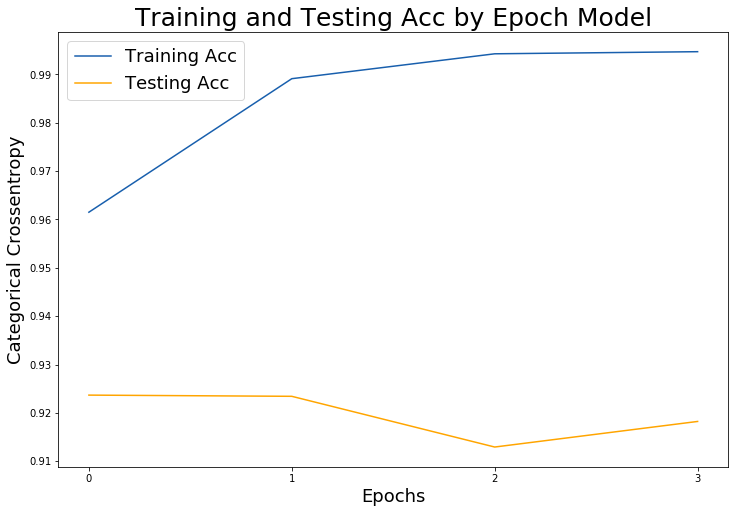

In [27]:
# accuracy visualization
train_acc = history.history['acc']
test_acc = history.history['val_acc']
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Acc', color='#185fad')
plt.plot(test_acc, label='Testing Acc', color='orange')
plt.title('Training and Testing Acc by Epoch Model', fontsize = 25)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(4), np.arange(10))
plt.legend(fontsize = 18);

In [22]:
# value for test loss and accuracy
score = model.evaluate(test_data,
                       verbose=1)

labels = model.metrics_names

print(labels[0], score[0])
print(labels[1], score[1])

505/505 [==============================] - 68s 134ms/step - loss: 0.9278 - acc: 0.9237
loss 0.9277696215280212
acc 0.92366743


In [23]:
sum(y_pred_class.flatten())

123

In [24]:
sum(y_pred_class)

array([123], dtype=int32)

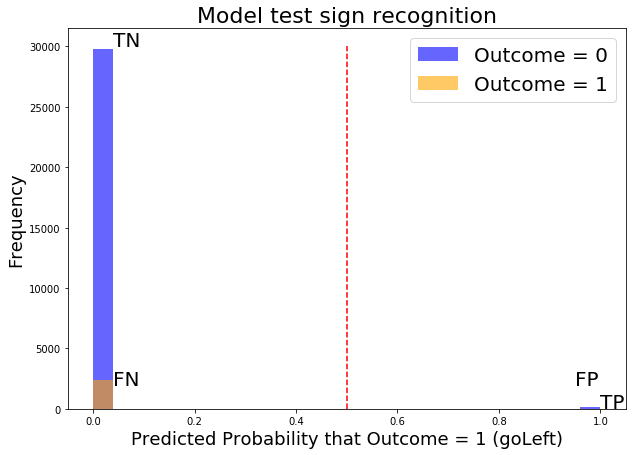

In [25]:
# distribution of outcome

pred_proba_df = pd.DataFrame({
    'true' : test_data.classes,
    'pred_prob' : y_pred_class.flatten()
})

# Adapt from notes Classification Metrics II

# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_proba_df[pred_proba_df['true'] == 0]['pred_prob'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_proba_df[pred_proba_df['true'] == 1]['pred_prob'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 30000,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 30000),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.04, 2000),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.95, 2000),
             s = 'FP',
             size = 20)

plt.annotate(xy = (1, 50),
             s = 'TP',
             size = 20)

# Label axes.
plt.title('Model test sign recognition', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1 (goLeft)', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);